In [1]:
import Datos.Data_acq as data
from models import Encoder
from models import Decoder
from models import cVAE
import matplotlib.pyplot as plt
import importlib

Datos

In [ ]:
import importlib
importlib.reload(data)
x_train, x_test,x_val ,y_train, y_test,y_val, x_train_1, y_train_1 = data.get_mnist_data()

Usando mnist como dataset


Enconder decoder


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


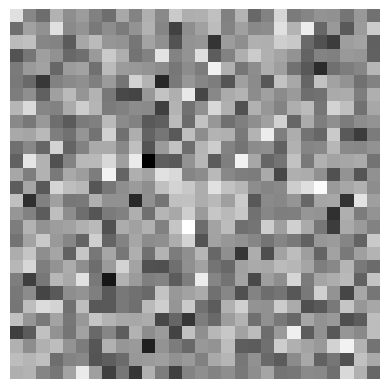

In [3]:
import importlib
import numpy as np
importlib.reload(Encoder)
importlib.reload(Decoder)

en = Encoder.build_enconder(intermediate_dim=256,latent_dim=128)
de = Decoder.build_decoder(intermediate_dim=256,latent_dim=128)


img_sample = np.expand_dims(x_train[0], axis=0)# shape (1, 28, 28)
cond_sample = np.expand_dims(y_train[0], axis=0) 
[z, z_mean, z_log_var] = en.predict([img_sample,cond_sample])

img_recons = de.predict([z,cond_sample])


plt.imshow(img_recons[0].reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()


In [4]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

importlib.reload(cVAE)
original_dim = 28*28
beta = 1.0
print(y_train)


train_dataset = tf.data.Dataset.from_tensor_slices(((x_train, y_train), x_train))
#train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
train_dataset = train_dataset.batch(128)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

val_dataset = tf.data.Dataset.from_tensor_slices(((x_val, y_val), x_val))
val_dataset = val_dataset.batch(128)


cvae = cVAE.CVAE(encoder=en, decoder=de, original_dim=original_dim, beta=1)
cvae.compile(optimizer=tf.keras.optimizers.Adam())



[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [5]:
cvae.fit(train_dataset,
        epochs=10,
        batch_size=128,
        validation_data=val_dataset,
        callbacks=[early_stopping]
         )

Epoch 1/10


430/430 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - kl_loss: 2.5742 - loss: 65.9370 - reconstruction_loss: 63.3628 - val_kl_loss: 4.2910 - val_loss: 40.8825 - val_reconstruction_loss: 36.6378
Epoch 2/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - kl_loss: 4.5680 - loss: 39.9322 - reconstruction_loss: 35.3642 - val_kl_loss: 4.8740 - val_loss: 36.3300 - val_reconstruction_loss: 31.4613
Epoch 3/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - kl_loss: 5.2684 - loss: 36.3849 - reconstruction_loss: 31.1165 - val_kl_loss: 5.6996 - val_loss: 34.5259 - val_reconstruction_loss: 28.8142
Epoch 4/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - kl_loss: 5.9048 - loss: 34.5805 - reconstruction_loss: 28.6757 - val_kl_loss: 5.9518 - val_loss: 32.8010 - val_reconstruction_loss: 26.8217
Epoch 5/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - kl_loss: 6.2378 - loss: 32.8262 - reconstruction_loss: 26.5884 - val_kl_loss: 6.2813 - val_loss: 31.2578 - val_reconstruction_loss: 24.9988
Epoch 6/10
430/430 ━━━━━━━━━━━━━

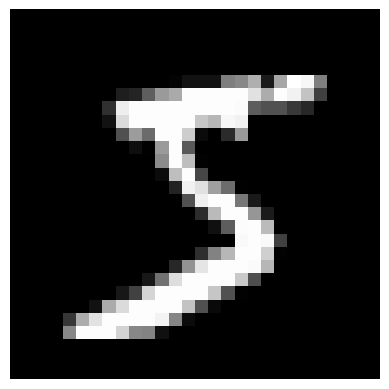

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
(1, 784)


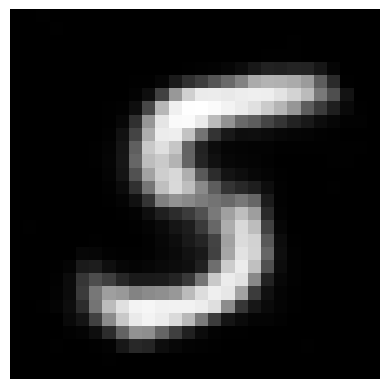

In [ ]:
x_input = x_train[:1]         # 1 imagen (shape: (1, 28, 28))
cond_input = y_train[:1]      # su condición (shape: (1, 10))

plt.imshow(x_input[0].reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()

z_mean, z_log_var, z = cvae.encoder.predict([x_input, cond_input])


# Paso por el decoder para reconstrucción
reconstructed = cvae.decoder.predict([z, cond_input])
print(reconstructed.shape)
plt.imshow(reconstructed[0].reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()



In [7]:
'''
# Tomá una imagen del conjunto de test
indices_de_testeo=[1, 3, 5, 7, 2, 0, 13, 15, 17, 4] # inidices donde para que x_train[inidicies] sea 0 1 2 3 4 5 6 7 8 9 0

for i in indices_de_testeo:

    imagen = x_train[i]
    #plt.imshow(imagen)
    #plt.show()
    # Visualizá cómo se reconstruye con todas las condiciones posibles
    vis.condiciones(cvae, imagen)
# Ver 10 variantes generadas para la clase 3
for i in range(10):
    
    vis.variantes(cvae, condicion_id=i, num_variantes=10)
'''

'\n# Tomá una imagen del conjunto de test\nindices_de_testeo=[1, 3, 5, 7, 2, 0, 13, 15, 17, 4] # inidices donde para que x_train[inidicies] sea 0 1 2 3 4 5 6 7 8 9 0\n\nfor i in indices_de_testeo:\n\n    imagen = x_train[i]\n    #plt.imshow(imagen)\n    #plt.show()\n    # Visualizá cómo se reconstruye con todas las condiciones posibles\n    vis.condiciones(cvae, imagen)\n# Ver 10 variantes generadas para la clase 3\nfor i in range(10):\n    \n    vis.variantes(cvae, condicion_id=i, num_variantes=10)\n'

# Predictores

In [8]:
import models.Predictor as predictores
importlib.reload(predictores)

predictor = predictores.build_predictor() 

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

predictor.compile(optimizer, loss="categorical_crossentropy")

#x_rain_conv = np.reshape(x_train,(28,28,1)) 
predictor.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    validation_data=(x_val, y_val)  # Include validation data
#    callbacks=[cp_callback_predictor_C2, early_stopping]  # Add early_stopping to callbacks
)

Model: "predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ original_input (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_layer (ReshapeLayer)    │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,570 (197.54 KB)

 Trainable params: 50,378 (196.79 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - loss: 0.6143 - val_loss: 0.3236
Epoch 2/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - loss: 0.1195 - val_loss: 0.0558
Epoch 3/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - loss: 0.0875 - val_loss: 0.0531
Epoch 4/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - loss: 0.0755 - val_loss: 0.0558
Epoch 5/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - loss: 0.0620 - val_loss: 0.0501


(784,)


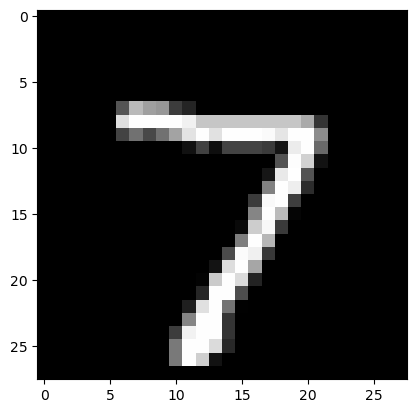

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Digito predicho: 7


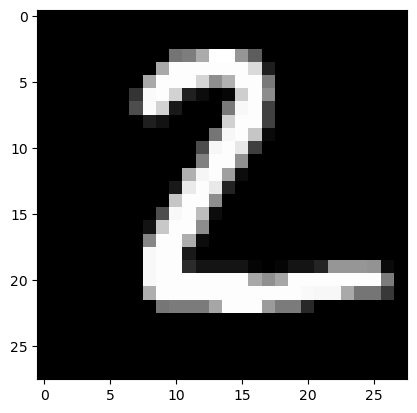

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Digito predicho: 2


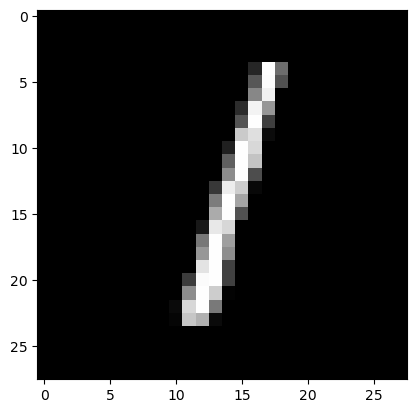

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Digito predicho: 1


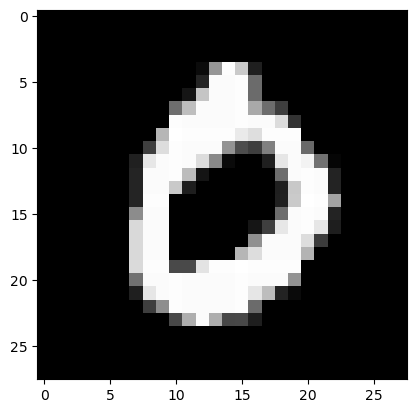

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Digito predicho: 0


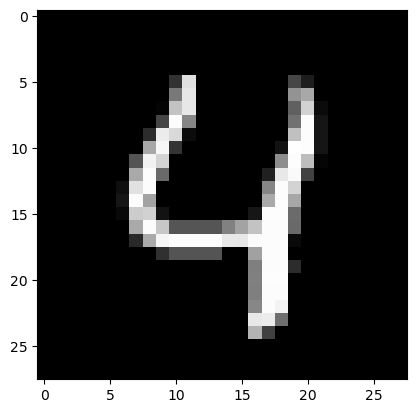

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Digito predicho: 4


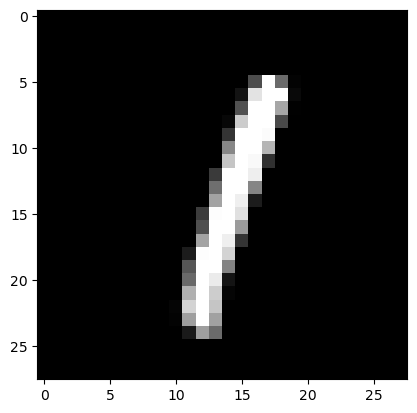

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Digito predicho: 1


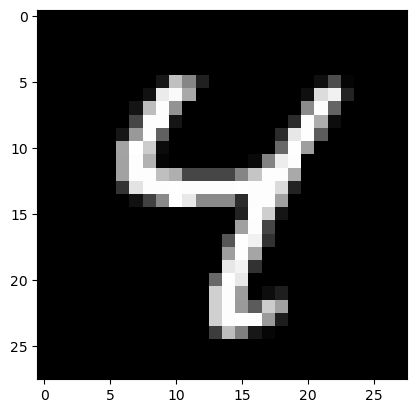

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Digito predicho: 4


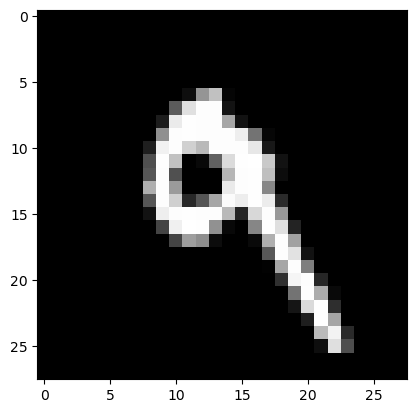

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Digito predicho: 9


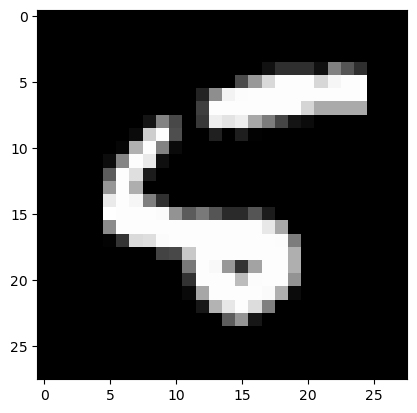

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Digito predicho: 5


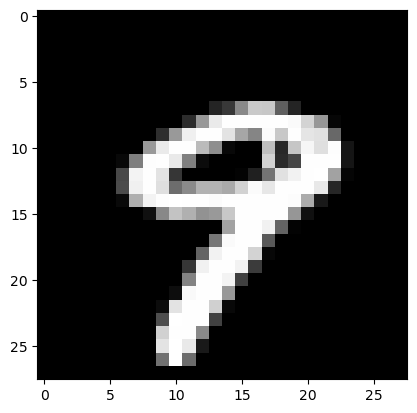

dentro del loop
(784,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Digito predicho: 9


In [9]:
print(x_test[0].shape)
for i in range(10):
    plt.imshow(x_test[i].reshape(28, 28),cmap="gray")
    plt.show()
    print("dentro del loop")
    print(x_test[i].shape)
    print(f"Digito predicho: {np.argmax( predictor.predict(x_test[i].reshape(1, 784)))}")

# Pruebas de separacion de digitos


Shape de x_train
(10, 784)
condition_decoder_1 shape: (10, 10)
x_filtrado_1 shape: (10, 784)
z shape: (10, 128)
condition_decoder_1 shape: (10, 10)
x_filtrado_1 shape: (10, 784)
z shape: (10, 128)
ITERACIÓN A:  0
condition_decoder_1 shape: (10, 10)
x_filtrado_1 shape: (10, 784)
z shape: (10, 128)
condition_decoder_1 shape: (10, 10)
x_filtrado_1 shape: (10, 784)
z shape: (10, 128)
ITERACIÓN A:  1
condition_decoder_1 shape: (10, 10)
x_filtrado_1 shape: (10, 784)
z shape: (10, 128)
condition_decoder_1 shape: (10, 10)
x_filtrado_1 shape: (10, 784)
z shape: (10, 128)
ITERACIÓN A:  2
condition_decoder_1 shape: (10, 10)
x_filtrado_1 shape: (10, 784)
z shape: (10, 128)
condition_decoder_1 shape: (10, 10)
x_filtrado_1 shape: (10, 784)
z shape: (10, 128)
ITERACIÓN A:  3
condition_decoder_1 shape: (10, 10)
x_filtrado_1 shape: (10, 784)
z shape: (10, 128)
condition_decoder_1 shape: (10, 10)
x_filtrado_1 shape: (10, 784)
z shape: (10, 128)
ITERACIÓN A:  4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━

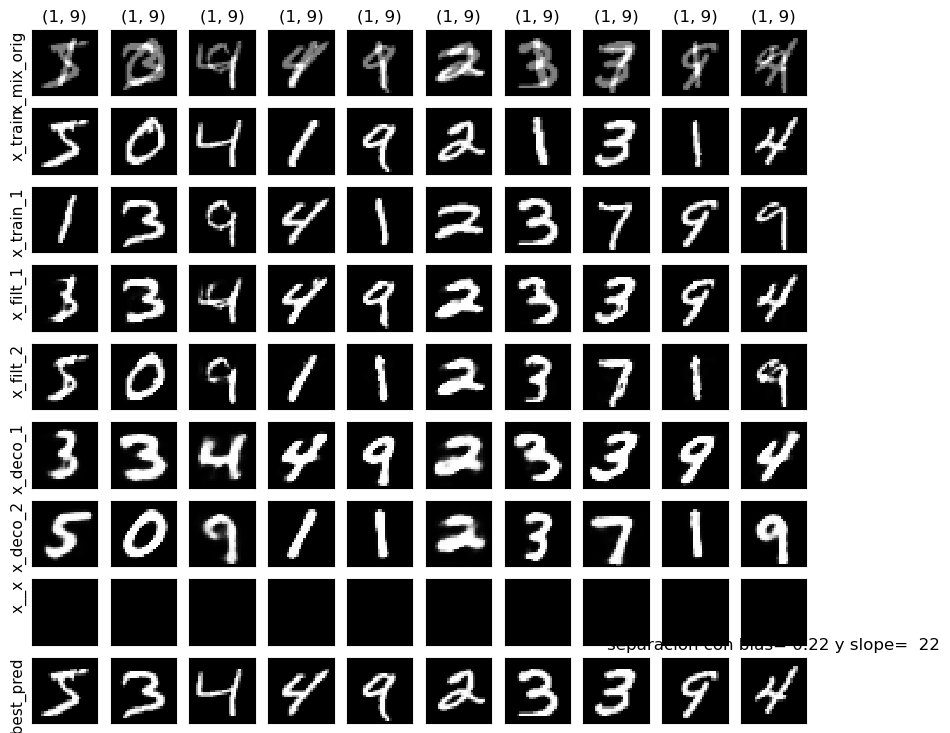

In [11]:
import inferencias.inferencia as inf
import importlib
importlib.reload(inf)

n_pictures=10

inf.separar_digitos(x_train[0:n_pictures],x_train_1[0:n_pictures],y_train[0:n_pictures],
                    y_train_1[0:n_pictures],cvae,predictor,num_col=n_pictures,show_graph=True,show_laten=False,Iterations=5 )